In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import TimeSeriesSplit

In [2]:
data=pd.read_csv('data_production')

In [3]:
data.head()

,Unnamed: 0,observation_date,Production,année,mois,saison
0,0,1939-01-01,3.3336,1939,1,1
1,1,1939-02-01,3.3591,1939,2,1
2,2,1939-03-01,3.4354,1939,3,2
3,3,1939-04-01,3.4608,1939,4,2
4,4,1939-05-01,3.4608,1939,5,2


In [4]:
# Suppression de la colonne 'Unnamed: 0'
data = data.drop(columns=['Unnamed: 0'])

In [5]:
data.head()

,observation_date,Production,année,mois,saison
0,1939-01-01,3.3336,1939,1,1
1,1939-02-01,3.3591,1939,2,1
2,1939-03-01,3.4354,1939,3,2
3,1939-04-01,3.4608,1939,4,2
4,1939-05-01,3.4608,1939,5,2


<h2>Préparation des données</h2>

In [6]:
# Data Preparation for LSTM with categorical features and date components
feature = data[[ 'Production', 'mois', 'saison', 'année']].copy()

# One-hot encode 'saison'
feature= pd.get_dummies(feature, columns=['saison'], drop_first=True)

In [7]:
scaler = MinMaxScaler()
numerical_cols = ['Production', 'mois', 'année']
data_scaled = feature.copy()
data_scaled[numerical_cols] = scaler.fit_transform(feature[numerical_cols])

<h2>Création des séquences</h2><br>permet au modèle de tirer parti des relations temporelles et d'améliorer sa capacité prédictive en intégrant les informations passées dans ses décisions actuelles.

In [8]:
# Function to create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length - 1):
        X.append(data[i:(i + seq_length)])
        y.append(data[i + seq_length, 0])  
    return np.array(X), np.array(y)

In [9]:
seq_length = 12
X, y = create_sequences(data_scaled.values, seq_length)

In [10]:

X = X.reshape(X.shape[0], X.shape[1], X.shape[2])

<h2>Reshape pour LSTM </h2>

Formatez les données d'entrée dans un format accepté par le réseau LSTM (n_samples, timesteps, n_features)

In [11]:
# Explicitly cast to float32
X = X.astype(np.float32)
y = y.astype(np.float32)

Validation croisée pour séries temporelles 

In [12]:
# Model Building and Training (with TimeSeriesSplit)
tscv = TimeSeriesSplit(n_splits=5)
rmse_scores = []


<h1>Entraînement d'un modèle LSTM</h1>

In [25]:
from sklearn.metrics import mean_squared_error
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    rmse_scores.append(rmse)


<h1>Évaluer la Précision du Modèle</h1>

In [26]:
print("RMSE scores for each fold:", rmse_scores)
print(f"Average RMSE: {np.mean(rmse_scores)}")

# Forecasting
last_sequence = data_scaled.values[-seq_length:]
last_sequence = last_sequence.reshape(1, seq_length, last_sequence.shape[1])

predicted_scaled = model.predict

RMSE scores for each fold: [0.01964592, 0.043236163, 0.03876328, 0.037336167, 0.030179264, 0.050313655, 0.03527833, 0.030276205, 0.04291032, 0.06225886, 0.06167919, 0.10069738, 0.033573844, 0.048731096, 0.031337656]
Average RMSE: 0.044414494186639786


<h1>Visualisation des Résultats de model</h1>

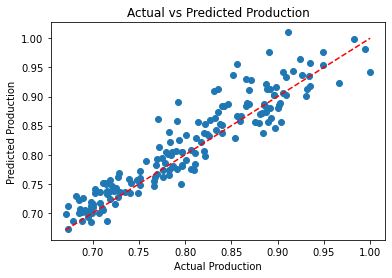

In [27]:
import matplotlib.pyplot as plt

# Scatter plot of predicted vs actual values
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Production")
plt.ylabel("Predicted Production")
plt.title("Actual vs Predicted Production")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.show()
